In [1]:
# default_exp statsmodels_intro

# Statsmodels introduction

> Introducing different discrete choice models using statsmodels.

In [2]:
#hide
from nbdev.showdoc import *

### Start model introduction

#### Loading modules and functions

In [26]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import patsy

#### Loading data

In [27]:
df = sm.datasets.get_rdataset("Guerry", "HistData")
type(df), type(df.data)

(statsmodels.datasets.utils.Dataset, pandas.core.frame.DataFrame)

In [28]:
df = df.data
df.head()

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,...,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,...,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,...,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,...,46,42,76,66,16,85,34,161.927,7340,298.26
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,...,70,12,37,80,32,29,2,351.399,6925,155.90
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,...,22,23,64,79,35,7,1,320.280,5549,129.10


In [29]:
vars = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']
df = df[vars]
df.shape

(86, 5)

In [30]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C
85,Corse,83,49,37,NaN


In [31]:
df.isna().sum()

Department    0
Lottery       0
Literacy      0
Wealth        0
Region        1
dtype: int64

In [32]:
df = df.dropna()
df.shape, df.dtypes

((85, 5),
 Department    object
 Lottery        int64
 Literacy       int64
 Wealth         int64
 Region        object
 dtype: object)

In [33]:
df['Region'].value_counts()

C    17
E    17
N    17
W    17
S    17
Name: Region, dtype: int64

#### Designed matrices and model

In [34]:
# Prepare data
y, X = patsy.dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')
y[:3], X[:3]

(   Lottery
 0     41.0
 1     38.0
 2     66.0,
    Intercept  Region[T.E]  Region[T.N]  Region[T.S]  Region[T.W]  Literacy  \
 0        1.0          1.0          0.0          0.0          0.0      37.0   
 1        1.0          0.0          1.0          0.0          0.0      51.0   
 2        1.0          0.0          0.0          0.0          0.0      13.0   
 
    Wealth  
 0    73.0  
 1    22.0  
 2    61.0  )

In [40]:
mod = sm.OLS(y, X)    # Describe model
res = mod.fit()


#### Results

In [ ]:
res.summary()

In [36]:
res.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

In [37]:
res.rsquared

0.3379508691928822

In [38]:
sm.stats.linear_rainbow(res)

(0.847233997615691, 0.6997965543621644)

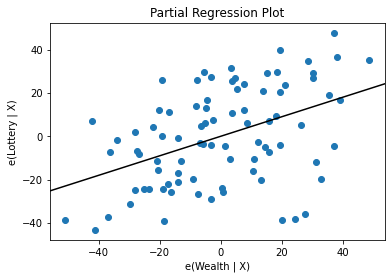

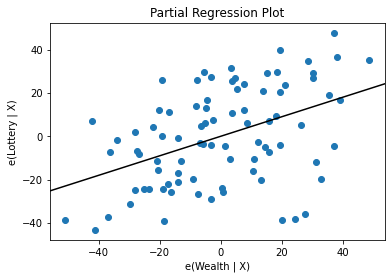

In [39]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'],
   ....:                              data=df, obs_labels=False)

### Discrete choice basic with statsmodels

In [41]:
import numpy as np
import statsmodels.api as sm

In [43]:
# Load data
spector_data = sm.datasets.spector.load(as_pandas=False)
spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)
print(spector_data.exog[:5,:])
print(spector_data.endog[:5])

[[ 2.66 20.    0.    1.  ]
 [ 2.89 22.    0.    1.  ]
 [ 3.28 24.    0.    1.  ]
 [ 2.92 12.    0.    1.  ]
 [ 4.   21.    0.    1.  ]]
[0. 0. 0. 0. 1.]


In [54]:
# Get pandas data frame
df = sm.datasets.spector.load(as_pandas=True).data
df[:5], type(df)

(    GPA  TUCE  PSI  GRADE
 0  2.66  20.0  0.0    0.0
 1  2.89  22.0  0.0    0.0
 2  3.28  24.0  0.0    0.0
 3  2.92  12.0  0.0    0.0
 4  4.00  21.0  0.0    1.0,
 pandas.core.frame.DataFrame)

#### Linear Probability Model (OLS)

In [57]:
lpm_mod = sm.OLS(spector_data.endog, spector_data.exog)
lpm_res = lpm_mod.fit()
print('Parameters: ', lpm_res.params[:-1])

Parameters:  [ 0.46385168  0.01049512  0.37855479 -1.49801712]


In [58]:
# Option 2: using pandas
y, X = patsy.dmatrices('GRADE ~ GPA + TUCE + PSI', df)
lpm2 = sm.OLS(y, X)
res2 = lpm2.fit()
res2.params[1:]

array([0.46385168, 0.01049512, 0.37855479])

In [66]:
def test_eq(pred, targ):
    diff = np.sum(pred - targ)
    assert diff < 1e-10

In [67]:
test_eq(lpm_res.params[:-1], res2.params[1:])

#### Logit Model

In [46]:
logit_mod = sm.Logit(spector_data.endog, spector_data.exog)
logit_res = logit_mod.fit(disp=0)
print('Parameters: ', logit_res.params)

Parameters:  [  2.82611259   0.09515766   2.37868766 -13.02134686]


In [69]:
# Option 2: using pandas
logit2 = sm.Logit(y,X)
res2   = logit2.fit()
res2.params

Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7


array([-13.02134686,   2.82611259,   0.09515766,   2.37868766])

In [70]:
test_eq(logit_res.params[:-1], res2.params[1:])

In [104]:
# Option 3: direct pandas
# logit3 = sm.Logit('GRADE ~ GPA + TUCE + PSI', df)

In [71]:
# Marginal effects
marg = res2.get_margeff()
marg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  GRADE
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GPA            0.3626      0.109      3.313      0.001       0.148       0.577
TUCE           0.0122      0.018      0.686      0.493      -0.023       0.047
PSI            0.3052      0.092      3.304      0.001       0.124       0.486
==============================================================================
"""

#### Probit Model

In [74]:
probit_mod = sm.Probit(spector_data.endog, spector_data.exog)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print('Parameters: ', probit_res.params)
print('Marginal effects: ')
print(probit_margeff.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations 6
Parameters:  [ 1.62581004  0.05172895  1.42633234 -7.45231965]
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3608      0.113      3.182      0.001       0.139       0.583
x2             0.0115      0.018      0.624      0.533      -0.025       0.048
x3             0.3165      0.090      3.508      0.000       0.140       0.493


#### Multinomial Logit

In [83]:
# Load data
anes_data = sm.datasets.anes96.load(as_pandas=False)
anes_exog = anes_data.exog
anes_exog = sm.add_constant(anes_exog, prepend=False)
print(anes_data.exog[:5,:])
print(anes_data.endog[:5])

[[-2.30258509  7.         36.          3.          1.        ]
 [ 5.24755025  3.         20.          4.          1.        ]
 [ 3.43720782  2.         24.          6.          1.        ]
 [ 4.4200447   3.         28.          6.          1.        ]
 [ 6.46162441  5.         68.          6.          1.        ]]
[6. 1. 1. 1. 0.]


In [84]:
# Fit MNL model
mlogit_mod = sm.MNLogit(anes_data.endog, anes_exog)
mlogit_res = mlogit_mod.fit()
print(mlogit_res.params)

Optimization terminated successfully.
         Current function value: 1.548647
         Iterations 7
[[-1.15359746e-02 -8.87506530e-02 -1.05966699e-01 -9.15567017e-02
  -9.32846040e-02 -1.40880692e-01]
 [ 2.97714352e-01  3.91668642e-01  5.73450508e-01  1.27877179e+00
   1.34696165e+00  2.07008014e+00]
 [-2.49449954e-02 -2.28978371e-02 -1.48512069e-02 -8.68134503e-03
  -1.79040689e-02 -9.43264870e-03]
 [ 8.24914421e-02  1.81042758e-01 -7.15241904e-03  1.99827955e-01
   2.16938850e-01  3.21925702e-01]
 [ 5.19655317e-03  4.78739761e-02  5.75751595e-02  8.44983753e-02
   8.09584122e-02  1.08894083e-01]
 [-3.73401677e-01 -2.25091318e+00 -3.66558353e+00 -7.61384309e+00
  -7.06047825e+00 -1.21057509e+01]]


In [87]:
mlogit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  944
Model:                        MNLogit   Df Residuals:                      908
Method:                           MLE   Df Model:                           30
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:                  0.1648
Time:                        14:48:17   Log-Likelihood:                -1461.9
converged:                       True   LL-Null:                       -1750.3
Covariance Type:            nonrobust   LLR p-value:                1.822e-102
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0115      0.034     -0.336      0.736      -0.079       0.056
x2             0.2977      0.094      3.180      0.001       0.114       0.481
x3            -0.0249      0.007     -3.823      0.000      -0.038      -0.012
x4             0.0825      0.074      1.121      0.262      -0.062       0.227
x5             0.0052      0.018      0.295      0.768      -0.029       0.040
const         -0.3734      0.630     -0.593      0.553      -1.608       0.861
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0888      0.039     -2.266      0.023      -0.166      -0.012
x2             0.3917      0.108      3.619      0.000       0.180       0.604
x3            -0.0229      0.008     -2.893      0.004      -0.038      -0.007
x4             0.1810      0.085      2.123      0.034       0.014       0.348
x5             0.0479      0.022      2.149      0.032       0.004       0.092
const         -2.2509      0.763     -2.949      0.003      -3.747      -0.755
------------------------------------------------------------------------------
       y=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1060      0.057     -1.858      0.063      -0.218       0.006
x2             0.5735      0.159      3.617      0.000       0.263       0.884
x3            -0.0149      0.011     -1.311      0.190      -0.037       0.007
x4            -0.0072      0.126     -0.057      0.955      -0.255       0.240
x5             0.0576      0.034      1.713      0.087      -0.008       0.123
const         -3.6656      1.157     -3.169      0.002      -5.932      -1.399
------------------------------------------------------------------------------
       y=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0916      0.044     -2.091      0.037      -0.177      -0.006
x2             1.2788      0.129      9.921      0.000       1.026       1.531
x3            -0.0087      0.008     -1.031      0.302      -0.025       0.008
x4             0.1998      0.094      2.123      0.034       0.015       0.384
x5             0.0845      0.026      3.226      0.001       0.033       0.136
const         -7.6138      0.958     -7.951      0.000      -9.491      -5.737
------------------------------------------------------------------------------
       y=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0933      0.039     -2.371      0.018      -0.170      -0.016
x2             1.3470      0.117     11.494      0.000       1.117       1.577
x3

### Logit model

In [102]:
affair_mod = logit("affair ~ occupation + educ + occupation_husb"
                   "+ rate_marriage + age + yrs_married + children"
                   " + religious", dta).fit()

Optimization terminated successfully.
         Current function value: 0.545314
         Iterations 6


In [105]:
affair_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 affair   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6357
Method:                           MLE   Df Model:                            8
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:                  0.1327
Time:                        15:31:23   Log-Likelihood:                -3471.5
converged:                       True   LL-Null:                       -4002.5
Covariance Type:            nonrobust   LLR p-value:                5.807e-224
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.7257      0.299     12.470      0.000       3.140       4.311
occupation          0.1602      0.034      4.717      0.000       0.094       0.227
educ               -0.0392      0.015     -2.533      0.011      -0.070      -0.009
occupation_husb     0.0124      0.023      0.541      0.589      -0.033       0.057
rate_marriage      -0.7161      0.031    -22.784      0.000      -0.778      -0.655
age                -0.0605      0.010     -5.885      0.000      -0.081      -0.040
yrs_married         0.1100      0.011     10.054      0.000       0.089       0.131
children           -0.0042      0.032     -0.134      0.893      -0.066       0.058
religious          -0.3752      0.035    -10.792      0.000      -0.443      -0.307
===================================================================================
"""

In [109]:
dta.shape, dta.affair.value_counts()

((6366, 10),
 0.0    4313
 1.0    2053
 Name: affair, dtype: int64)

In [113]:
def acc(cfmtx):
    return (cfmtx[0,0] + cfmtx[1,1])/np.sum(cfmtx)
#How well are we predicting?
affair_mod.pred_table(), acc(affair_mod.pred_table())

(array([[3882.,  431.],
        [1326.,  727.]]),
 0.7240025133521835)

In [114]:
mfx = affair_mod.get_margeff()
mfx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 affair
Method:                          dydx
At:                           overall
===================================================================================
                     dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
occupation          0.0293      0.006      4.744      0.000       0.017       0.041
educ               -0.0072      0.003     -2.538      0.011      -0.013      -0.002
occupation_husb     0.0023      0.004      0.541      0.589      -0.006       0.010
rate_marriage      -0.1308      0.005    -26.891      0.000      -0.140      -0.121
age                -0.0110      0.002     -5.937      0.000      -0.015      -0.007
yrs_married         0.0201      0.002     10.327      0.000       0.016       0.024
children           -0.0008      0.006     -0.134      0.893      -0.012       0.011
religious          -0.0685      0.006    -11.119      0.000      -0.081      -0.056
===================================================================================
"""

#### Logit vs Probit

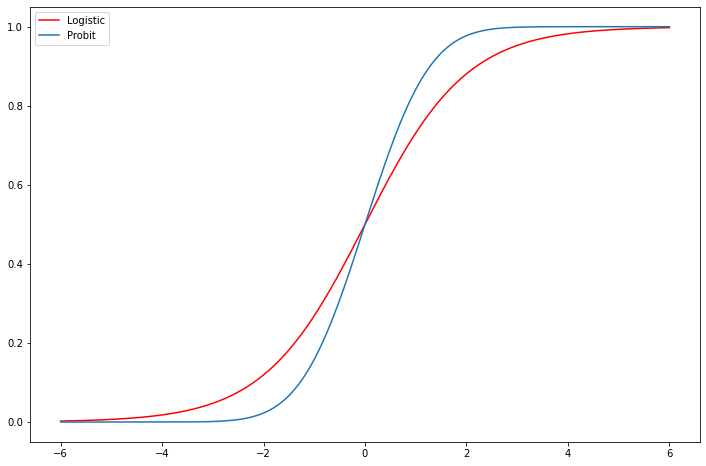

In [116]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
support = np.linspace(-6, 6, 1000)
ax.plot(support, stats.logistic.cdf(support), 'r-', label='Logistic')
ax.plot(support, stats.norm.cdf(support), label='Probit')
ax.legend();

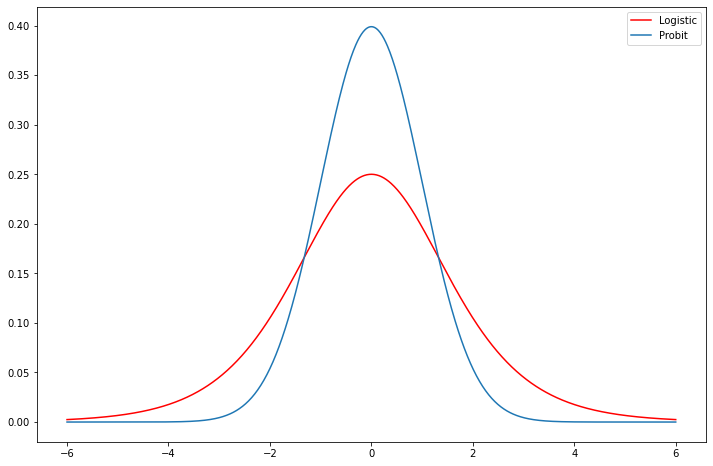

In [117]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
support = np.linspace(-6, 6, 1000)
ax.plot(support, stats.logistic.pdf(support), 'r-', label='Logistic')
ax.plot(support, stats.norm.pdf(support), label='Probit')
ax.legend();